# 문제4: 장르 탐색

## 수행목표

- KMRD 데이터셋의 장르 데이터를 확인하고 시각화한다.

## 수행단계

- 장르 탐색
  - 영화의 장르별 분포 (Bar chart) 및 장르별 평균 평점을 확인하라.

## 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import ipywidgets as widgets
from IPython.display import display, clear_output

## 데이터셋 확인

In [2]:
KMRD_PATH = "kmrd-small"

### KMRD (Korean Movie Recommender system Dataset)

In [3]:
kmrd_genres_path   = os.path.join(KMRD_PATH, "genres.csv")
kmrd_movies_path   = os.path.join(KMRD_PATH, "movies.txt")
kmrd_rates_path    = os.path.join(KMRD_PATH, "rates.csv")

In [4]:

# Load CSV files
df_kmrd_genres    = pd.read_csv(kmrd_genres_path)
df_kmrd_rates     = pd.read_csv(kmrd_rates_path)

In [5]:
missing_movie_ids = set();

def extract_eng_year(s, year_kor=None):
    """
    If s matches the pattern: "Something , 4-digit-year"
    return (english_title, year_original_as_float).
    Otherwise, return (s, None).
    """
    pattern = r"^(.*?)\s*,\s*(\d{4})$"
    match = re.match(pattern, s.strip())
    if match:
        eng = match.group(1).strip()
        yr  = float(match.group(2))
        return eng, yr
    else:
        if year_kor and year_kor.isnumeric() and s.strip() == year_kor:
            return None, float(s.strip())
        return s.strip(), None

def parse_movies_txt(filepath):
    """
    Reads the movies.txt line by line, ignoring empty lines,
    and splits into columns: 
        movie (str), 
        title_kor (str), 
        title_eng (str), 
        year_original (float), 
        year_korea (float), 
        grade (str)
    
    year_original and year_korea might be NaN if not found.
    We ONLY drop lines if BOTH the Korean title AND English title are missing.
    """
    records = []
    with open(filepath, 'r', encoding='utf-8') as f:
        f.readline()
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split('\t')
            if len(parts) < 2:
                missing_movie_ids.add(parts[0])
                continue
            
            movie_id    = None
            title_kor   = None
            title_eng   = None
            year_original   = None
            year_korea  = None
            grade       = None
            
            movie_id  = parts[0].strip() if len(parts) >= 1 else None
            title_kor = parts[1].strip() if len(parts) >= 2 else None

            extra_cols = parts[2:]
            

            # Possible cases:
            #  - 0 extra_cols => [movie_id, title_kor]
            #  - 1 extra_cols => [movie_id, title_kor, title_eng+year]
            #  - 2 extra_cols => [movie_id, title_kor, title_eng+year, year_korea]
            #  - 3 extra_cols => [movie_id, title_kor, title_eng+year, year_korea, grade]
            #                 => [movie_id, title_kor, year, year_korea, grade]
            #  - 4 extra_cols => [movie_id, title_kor, title_eng+year, year_korea, grade, ???]
            
            if len(extra_cols) == 1:
                t_eng, y_original = extract_eng_year(extra_cols[0])
                title_eng   = t_eng
                year_original   = y_original
            elif len(extra_cols) == 2:
                t_eng, y_original = extract_eng_year(extra_cols[0])
                title_eng  = t_eng
                year_original  = y_original
                
                try:
                    year_korea = float(extra_cols[1])
                except ValueError:
                    grade = extra_cols[1].strip()
            elif len(extra_cols) == 3:
                t_eng, y_original = extract_eng_year(extra_cols[0], extra_cols[1])
                title_eng  = t_eng
                year_original  = y_original
                
                try:
                    year_korea = float(extra_cols[1])
                except ValueError:
                    if extra_cols[1].strip():
                        grade = extra_cols[1].strip()
                
                if grade is None:
                    grade = extra_cols[2].strip()
            else:
                if len(extra_cols) == 0:
                    pass
                else:
                    t_eng, y_original = extract_eng_year(extra_cols[0])
                    title_eng  = t_eng
                    year_original  = y_original
                    if len(extra_cols) >= 2:
                        try:
                            year_korea = float(extra_cols[1])
                        except ValueError:
                            grade = extra_cols[1].strip()
                    if len(extra_cols) >= 3 and grade is None:
                        grade = extra_cols[2].strip()
            
            records.append({
                "movie": movie_id if movie_id else None,
                "title_kor": title_kor if title_kor else None,
                "title_eng": title_eng if title_eng else None,
                "year_original": year_original,
                "year_korea": year_korea,
                "grade": grade if grade else None
            })
    
    df = pd.DataFrame(records)
    
    df = df[df['movie'].notna() & (df['movie'] != '')]
    
    mask_titles_missing = df['title_kor'].isna() & df['title_eng'].isna()
    df = df[~mask_titles_missing]
    
    return df

In [6]:
df_kmrd_movies = parse_movies_txt(kmrd_movies_path)
print(df_kmrd_movies.shape)
df_kmrd_movies.head(100)

(992, 6)


,movie,title_kor,title_eng,year_original,year_korea,grade
0,10001,시네마 천국,Cinema Paradiso,1988.0,2013.0,전체 관람가
1,10002,빽 투 더 퓨쳐,Back To The Future,1985.0,2015.0,12세 관람가
2,10003,빽 투 더 퓨쳐 2,Back To The Future Part 2,1989.0,2015.0,12세 관람가
3,10004,빽 투 더 퓨쳐 3,Back To The Future Part III,1990.0,1990.0,전체 관람가
4,10005,스타워즈 에피소드 4 - 새로운 희망,Star Wars,1977.0,1997.0,PG
...,...,...,...,...,...,...
95,10096,고스트버스터즈 2,Ghostbusters II,1989.0,1990.0,PG
96,10097,굿모닝 베트남,"Good Morning, Vietnam",1987.0,NaN,15세 관람가
97,10098,자유의 댄스,Footloose,1984.0,NaN,PG
98,10099,남과 여,"Un Homme Et Une Femme , A Man And A Woman",1966.0,1979.0,15세 관람가


#### 데이터 조회 및 검사

##### Genres 정보

In [7]:
df_kmrd_genres.info()
df_kmrd_genres.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2025 entries, 0 to 2024
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   movie   2025 non-null   int64 
 1   genre   2025 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.8+ KB


,movie,genre
0,10001,드라마
1,10001,멜로/로맨스
2,10002,SF
3,10002,코미디
4,10003,SF


In [8]:
print("Unique values in KMRD Genres:")
print(df_kmrd_genres.nunique())

Unique values in KMRD Genres:
movie    964
genre     20
dtype: int64


##### Movies 정보

In [9]:
df_kmrd_movies.info()
df_kmrd_movies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie          992 non-null    object 
 1   title_kor      992 non-null    object 
 2   title_eng      977 non-null    object 
 3   year_original  987 non-null    float64
 4   year_korea     609 non-null    float64
 5   grade          957 non-null    object 
dtypes: float64(2), object(4)
memory usage: 46.6+ KB


,movie,title_kor,title_eng,year_original,year_korea,grade
0,10001,시네마 천국,Cinema Paradiso,1988.0,2013.0,전체 관람가
1,10002,빽 투 더 퓨쳐,Back To The Future,1985.0,2015.0,12세 관람가
2,10003,빽 투 더 퓨쳐 2,Back To The Future Part 2,1989.0,2015.0,12세 관람가
3,10004,빽 투 더 퓨쳐 3,Back To The Future Part III,1990.0,1990.0,전체 관람가
4,10005,스타워즈 에피소드 4 - 새로운 희망,Star Wars,1977.0,1997.0,PG


In [10]:
print("Unique values in KMRD Movies:")
print(df_kmrd_movies.nunique())

Unique values in KMRD Movies:
movie            992
title_kor        969
title_eng        957
year_original     79
year_korea        72
grade              9
dtype: int64


##### Ratings 정보

In [11]:
df_kmrd_rates.info()
df_kmrd_rates.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140710 entries, 0 to 140709
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   user    140710 non-null  int64
 1   movie   140710 non-null  int64
 2   rate    140710 non-null  int64
 3   time    140710 non-null  int64
dtypes: int64(4)
memory usage: 4.3 MB


,user,movie,rate,time
0,0,10003,7,1494128040
1,0,10004,7,1467529800
2,0,10018,9,1513344120
3,0,10021,9,1424497980
4,0,10022,7,1427627340


In [12]:
print("Unique values in KMRD Rates:")
df_kmrd_rates.nunique()

Unique values in KMRD Rates:


user      52028
movie       600
rate         10
time     136972
dtype: int64

## 데이터 결측치 및 이상치 확인

#### 결측치 확인

- movies.txt 의 경우 이미 결측치가 제거된 상태임

In [13]:
print("KMRD Genres shape:", df_kmrd_genres.shape)
print("KMRD Movies shape:", df_kmrd_movies.shape)
print("KMRD Rates shape:", df_kmrd_rates.shape)

KMRD Genres shape: (2025, 2)
KMRD Movies shape: (992, 6)
KMRD Rates shape: (140710, 4)


In [14]:
df_kmrd_genres = df_kmrd_genres.dropna()
df_kmrd_genres = df_kmrd_genres.drop_duplicates()
print("KMRD Genres shape after dropping na values:", df_kmrd_genres.shape)

KMRD Genres shape after dropping na values: (2025, 2)


In [15]:
df_kmrd_rates = df_kmrd_rates.dropna()
df_kmrd_rates = df_kmrd_rates.drop_duplicates()
print("KMRD Ratings shape after dropping na values:", df_kmrd_rates.shape)

KMRD Ratings shape after dropping na values: (140678, 4)


#### 이상치 확인

##### Ratings 정보

In [16]:
print(df_kmrd_rates['rate'].describe())

out_of_range = df_kmrd_rates[ (df_kmrd_rates['rate'] < 1) | (df_kmrd_rates['rate'] > 10) ]
print("Out-of-range rating rows:", len(out_of_range))

df_kmrd_rates['zscore_rate'] = stats.zscore(df_kmrd_rates['rate'].astype(float))
outliers = df_kmrd_rates[ df_kmrd_rates['zscore_rate'].abs() > 3 ]
print("Potential outliers (|z|>3) in rating:", len(outliers))

df_kmrd_rates_zscore = df_kmrd_rates[ df_kmrd_rates['zscore_rate'].abs() <= 3 ]
print("KMRD Ratings shape after dropping invalid ratings:", df_kmrd_rates_zscore.shape)

user_counts = df_kmrd_rates_zscore['user'].value_counts()
user_counts = user_counts[user_counts >= 30]
df_kmrd_rates_rating_count = df_kmrd_rates_zscore[df_kmrd_rates_zscore['user'].isin(user_counts.index)]
print("KMRD Ratings shape after dropping users with less than 30 ratings:", df_kmrd_rates_rating_count.shape)

count_by_movie = df_kmrd_rates.groupby('movie')['rate'].count().reset_index(name='rating_count')
df_kmrd_rates_movie_count = df_kmrd_rates.merge(count_by_movie, on='movie', how='left', validate='many_to_one')
threshold = 30
df_kmrd_rates_movie_count_filtered = df_kmrd_rates_movie_count[df_kmrd_rates_movie_count['rating_count'] >= threshold].copy()
print("Total movies before filtering:", df_kmrd_rates['movie'].nunique())
print("Total movies after filtering (>=30 ratings):", df_kmrd_rates_movie_count_filtered['movie'].nunique())

df_kmrd_rates = df_kmrd_rates.drop('zscore_rate', axis=1)

count    140678.000000
mean          8.953433
std           2.105626
min           1.000000
25%           9.000000
50%          10.000000
75%          10.000000
max          10.000000
Name: rate, dtype: float64
Out-of-range rating rows: 0
Potential outliers (|z|>3) in rating: 5964
KMRD Ratings shape after dropping invalid ratings: (134714, 5)
KMRD Ratings shape after dropping users with less than 30 ratings: (29502, 5)
Total movies before filtering: 600
Total movies after filtering (>=30 ratings): 409


##### 영화의 장르별 분포

## 데이터 시각화

##### 영화의 장르별 분포

In [17]:
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

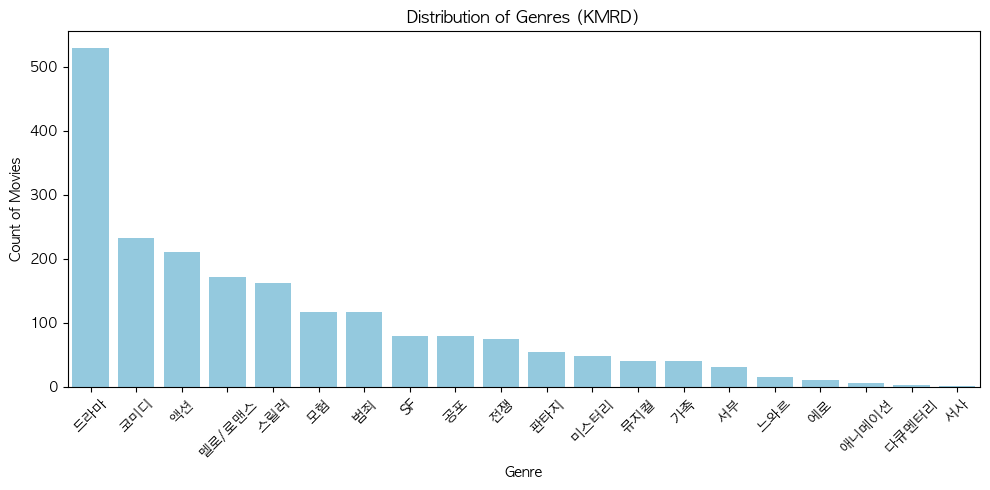

In [18]:
genre_counts = df_kmrd_genres['genre'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(x=genre_counts.index, y=genre_counts.values, color='skyblue')
plt.title("Distribution of Genres (KMRD)")
plt.xlabel("Genre")
plt.ylabel("Count of Movies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
print("Genre Count:\n", genre_counts)

Genre Count:
 genre
드라마       529
코미디       233
액션        211
멜로/로맨스    172
스릴러       162
모험        117
범죄        117
SF         80
공포         79
전쟁         75
판타지        55
미스터리       48
뮤지컬        41
가족         40
서부         31
느와르        15
에로         10
애니메이션       6
다큐멘터리       3
서사          1
Name: count, dtype: int64


##### 장르별 평점 분포

In [20]:
def plot_genre_avg_rating(rates_df, genres_df, title):
    """
    Merge rates_df with genres_df on 'movie'.
    Compute average rating by genre, then bar plot.
    """
    merged = pd.merge(rates_df, genres_df, on='movie', how='inner', validate='many_to_many')
    genre_avg = merged.groupby('genre')['rate'].mean().sort_values(ascending=False)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=genre_avg.index, y=genre_avg.values, color='skyblue')
    plt.title(f"Average Ratings by Genre - {title}")
    plt.xlabel("Genre")
    plt.ylabel("Average Rating")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return genre_avg

- 장르별 평균 평점

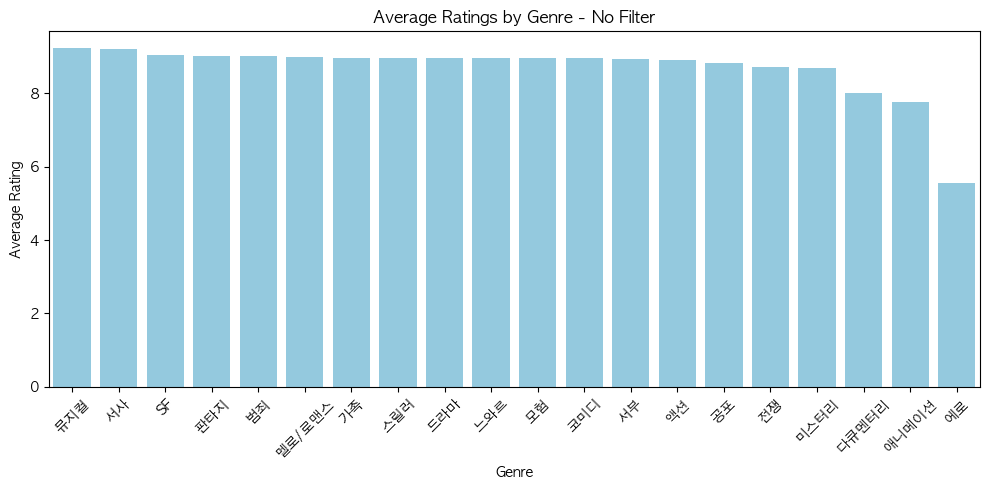

genre
뮤지컬       9.233173
서사        9.218182
SF        9.053571
판타지       9.034964
범죄        9.013502
멜로/로맨스    9.007856
가족        8.976670
스릴러       8.976206
드라마       8.966242
느와르       8.965129
모험        8.959833
코미디       8.954027
서부        8.947997
액션        8.912336
공포        8.834467
전쟁        8.714723
미스터리      8.692375
다큐멘터리     8.000000
애니메이션     7.760434
에로        5.564103
Name: rate, dtype: float64

In [21]:
plot_genre_avg_rating(df_kmrd_rates, df_kmrd_genres, "No Filter")

- 장르별 평균 평점 (|z| <= 3)

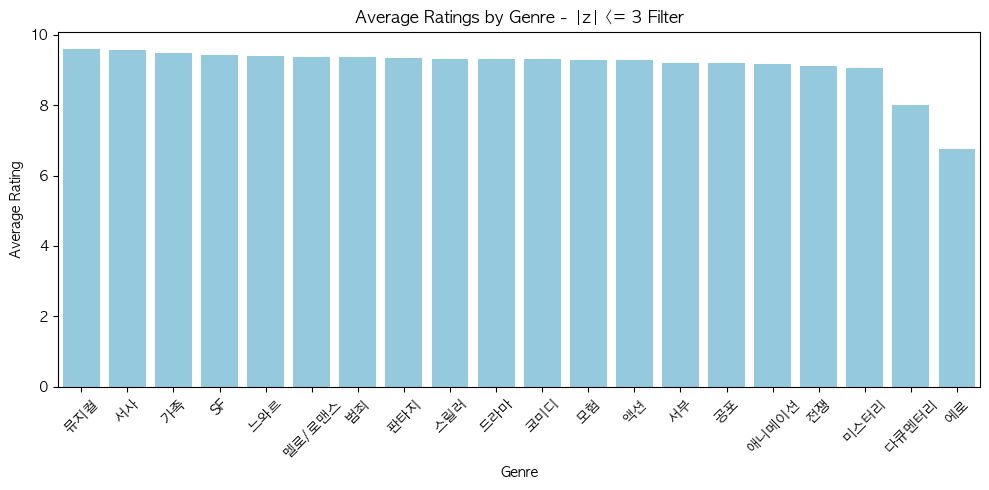

genre
뮤지컬       9.600942
서사        9.565877
가족        9.482352
SF        9.427288
느와르       9.384756
멜로/로맨스    9.362054
범죄        9.352855
판타지       9.351127
스릴러       9.310639
드라마       9.305687
코미디       9.301022
모험        9.290339
액션        9.273012
서부        9.201671
공포        9.185131
애니메이션     9.171891
전쟁        9.109826
미스터리      9.046752
다큐멘터리     8.000000
에로        6.762295
Name: rate, dtype: float64

In [22]:
plot_genre_avg_rating(df_kmrd_rates_zscore, df_kmrd_genres, "|z| <= 3 Filter")

- 장르별 평균 평점 (30개 이상의 평점을 남긴 유저)

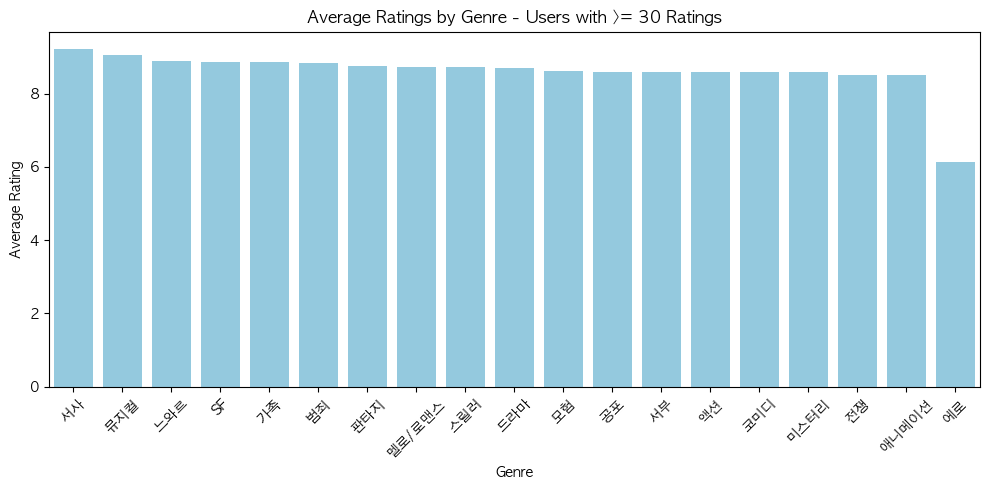

genre
서사        9.222222
뮤지컬       9.055446
느와르       8.889318
SF        8.865719
가족        8.853737
범죄        8.834857
판타지       8.762443
멜로/로맨스    8.725971
스릴러       8.711556
드라마       8.703234
모험        8.624038
공포        8.601219
서부        8.596154
액션        8.589860
코미디       8.586426
미스터리      8.585202
전쟁        8.496760
애니메이션     8.492462
에로        6.144928
Name: rate, dtype: float64

In [23]:
plot_genre_avg_rating(df_kmrd_rates_rating_count, df_kmrd_genres, "Users with >= 30 Ratings")

- 장르별 평균 평점 (30개 이상의 평점을 받은 영화)

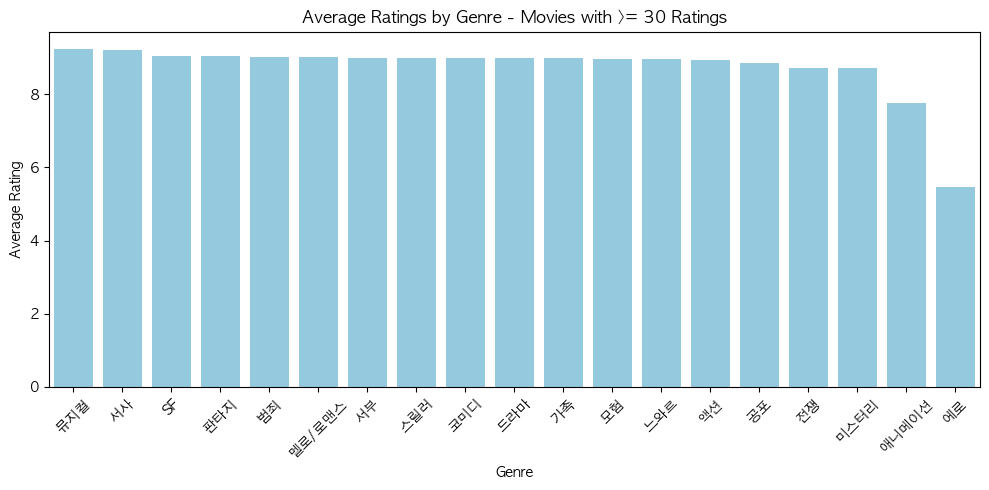

genre
뮤지컬       9.247763
서사        9.218182
SF        9.056982
판타지       9.037670
범죄        9.028182
멜로/로맨스    9.026978
서부        9.004006
스릴러       8.989974
코미디       8.986577
드라마       8.984355
가족        8.982379
모험        8.980158
느와르       8.977397
액션        8.929640
공포        8.848164
전쟁        8.733599
미스터리      8.712438
애니메이션     7.760434
에로        5.463768
Name: rate, dtype: float64

In [24]:
plot_genre_avg_rating(df_kmrd_rates_movie_count_filtered, df_kmrd_genres, "Movies with >= 30 Ratings")

In [25]:
df_genre_30 = pd.merge(df_kmrd_rates_movie_count_filtered, df_kmrd_genres, on='movie', how='inner', validate='many_to_many')

df_kmrd_movies['movie'] = df_kmrd_movies['movie'].astype(int)

df_genre_30 = pd.merge(df_genre_30, df_kmrd_movies, on='movie', how='left', validate='many_to_one')


In [26]:
df_genre_30.head(100)

,user,movie,rate,time,zscore_rate,rating_count,genre,title_kor,title_eng,year_original,year_korea,grade
0,0,10003,7,1494128040,-0.927724,989,SF,빽 투 더 퓨쳐 2,Back To The Future Part 2,1989.0,2015.0,12세 관람가
1,0,10003,7,1494128040,-0.927724,989,코미디,빽 투 더 퓨쳐 2,Back To The Future Part 2,1989.0,2015.0,12세 관람가
2,0,10004,7,1467529800,-0.927724,700,서부,빽 투 더 퓨쳐 3,Back To The Future Part III,1990.0,1990.0,전체 관람가
3,0,10004,7,1467529800,-0.927724,700,SF,빽 투 더 퓨쳐 3,Back To The Future Part III,1990.0,1990.0,전체 관람가
4,0,10004,7,1467529800,-0.927724,700,판타지,빽 투 더 퓨쳐 3,Back To The Future Part III,1990.0,1990.0,전체 관람가
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,10217,8,1423819860,-0.452804,581,액션,로보캅,RoboCop,1987.0,1987.0,15세 관람가
96,0,10217,8,1423819860,-0.452804,581,범죄,로보캅,RoboCop,1987.0,1987.0,15세 관람가
97,0,10218,7,1425733320,-0.927724,186,SF,로보캅 2,Robocop 2,1990.0,1990.0,15세 관람가
98,0,10218,7,1425733320,-0.927724,186,액션,로보캅 2,Robocop 2,1990.0,1990.0,15세 관람가


In [27]:
import ipywidgets as widgets
from IPython.display import display, clear_output

all_genres = sorted(df_kmrd_genres['genre'].unique())
genre_dropdown = widgets.Dropdown(
    options=all_genres,
    value=all_genres[0],
    description='Genre:',
    disabled=False
)

show_button = widgets.Button(
    description='Show Top 10 Movies',
    disabled=False,
    button_style='',
    tooltip='Click to show top 10 rated movies for the selected genre'
)

def on_show_button_click(b):
    clear_output(wait=True)
    display(genre_dropdown, show_button)

    selected_genre = genre_dropdown.value

    df_sub = df_genre_30[df_genre_30['genre'] == selected_genre].copy()
    if df_sub.empty:
        print(f"No movies found for genre '{selected_genre}'.")
        return
    
    movie_avg = df_sub.groupby('movie')['rate'].mean().sort_values(ascending=False).reset_index()
    movie_avg = movie_avg.merge(df_kmrd_movies, how='left', on='movie')
    
    movie_avg = movie_avg.rename(columns={'rate': 'avg_rating'})
    movie_avg = movie_avg.sort_values(by='avg_rating', ascending=False)
    
    top_10 = movie_avg.head(10).copy()
    top_10 = top_10[['movie', 'title_kor', 'title_eng', 'avg_rating']]
    print(f"Top 10 Highest Rated Movies for Genre = {selected_genre}, (>=30 total ratings):\n")
    display(top_10)

show_button.on_click(on_show_button_click)

display(genre_dropdown, show_button)


Dropdown(description='Genre:', options=('SF', '가족', '공포', '느와르', '다큐멘터리', '드라마', '멜로/로맨스', '모험', '뮤지컬', '미스터리'…

Button(description='Show Top 10 Movies', style=ButtonStyle(), tooltip='Click to show top 10 rated movies for t…

## 결론

- 단계1-과정2-문제3 에서 수행한 내용을 바탕으로 영화의 장르별 분포와 장르별 평점을 확인하였는데, 태그 (장르) 별로 나누어 보니 매우 조금 더 추천 시스템에 가까워진 것 같다.